In [107]:
#!git clone git@github.com:cisagov/vulnrichment.git    

## Read CWE values

1. Clone Vulnrichment JSON files
2. Extract the CVE Description, and CWE info from the Vulnrichment JSON files to a CSV file
   1. Indicate which CNA assigned the CWE 
   1. One CWE per line per CVE
   2. The providerMetadata 
      1. shortName 
      2. dateUpdated
3. Clean up the Description 
4. Save all entries to a file
5. Save entries with CWEs to a file. This is the one that will be input to CWE Map to assign or validate a CWE.

A CVE can contain no CWEs e.g. https://github.com/cisagov/vulnrichment/blob/ad2ab8e7bc7a207cd306ba2b876eff568e239e3b/2021/1xxx/CVE-2021-1675.json#L12

A CWE can be in one or both
* ADP container (CISA)
* CNA container 

CVE Description can be blank

Examples
* 2024/32xxx/CVE-2024-32017.json
    * https://github.com/cisagov/vulnrichment/blob/4380ad1a5f932ba6a29fd01dc825d03a9547196d/2024/32xxx/CVE-2024-32017.json#L19 has CWE-120 in the CNA container.
*  2024/0xxx/CVE-2024-0042.json has 
     * 'unknown' in the CNA container https://github.com/cisagov/vulnrichment/blob/7a8e01764e5ae28d6ef713ecf7c12b9d618c6254/2024/0xxx/CVE-2024-0042.json#L25
     * CWE-843 in the ADP container https://github.com/cisagov/vulnrichment/blob/7a8e01764e5ae28d6ef713ecf7c12b9d618c6254/2024/0xxx/CVE-2024-0042.json#L119

In [108]:
import os
import json
import csv
import pandas as pd
import numpy as np
import re
import unicodedata
import matplotlib.pyplot as plt
from datetime import datetime

In [109]:
# Files
root_directory = './vulnrichment/' # Directory containing JSON files
output_file_path = 'data_out/extracted_cwe_info.csv'# All entries
cwe_only_output_file_path = 'data_out/extracted_cwe_info_only.csv' # Entries with CWEs only
cwe_only_cisa_adp_output_file_path = 'data_out/extracted_cwe_info_cisa_adp_only.csv' # Entries with CWEs only
cwe_only_cisa_adp_linux_output_file_path  = 'data_out/extracted_cwe_info_cisa_adp_linux_only.csv' # Entries with CWEs only with Linux Descriptions pre-processed to remove traces

In [110]:
def extract_cwe_info_from_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        cwe_info_list = []
        filename = os.path.basename(file_path)
        cve_id = os.path.splitext(filename)[0]
        
        containers = data.get('containers', {})
        if containers:
            for container_name, container_data in containers.items():
                cwe_info_list.extend(extract_cwe_info(container_data, filename, container_name))

        # Extract CVE description from the first container that has it
        cve_description = ''
        for container_data in containers.values():
            cve_description = extract_cve_description(container_data)
            if cve_description:
                break

        for info in cwe_info_list:
            info['CVE_Description'] = cve_description

        return cwe_info_list

def extract_cwe_info(container_data, filename, container_name):
    cve_id = os.path.splitext(os.path.basename(filename))[0]
    cwe_info = []
    
    if isinstance(container_data, dict):
        container_data = [container_data]
    
    for entry in container_data:
        info = {
            'cve_id': cve_id,
            'Container': container_name
        }
        
        # Extract providerMetadata fields
        provider_metadata = entry.get('providerMetadata', {})
        for key, value in provider_metadata.items():
            info[f'{container_name}_providerMetadata_{key}'] = value
        
        problem_types = entry.get('problemTypes', [])
        cwe_found = False
        for problem in problem_types:
            descriptions = problem.get('descriptions', [])
            for description in descriptions:
                cwe_id = description.get('cweId')
                cwe_description = description.get('description')
                if cwe_id and cwe_description:
                    cwe_info_entry = info.copy()
                    cwe_info_entry.update({
                        'CWE_ID': cwe_id,
                        'CWE_Description': cwe_description
                    })
                    cwe_info.append(cwe_info_entry)
                    cwe_found = True
        
        # If no CWE info found, still add the entry with providerMetadata
        if not cwe_found:
            cwe_info.append(info)
    
    return cwe_info

#language can be en', en-US', "de",...
def extract_cve_description(container_data):
    descriptions = container_data.get('descriptions', []) if isinstance(container_data, dict) else container_data
    for desc in descriptions:
        if desc.get('lang'):
            return desc.get('value', '')
    return ''

def extract_cwe_info_from_directory(root_dir):
    all_cwe_info = []
    for root, _, files in os.walk(root_dir):
        for file_name in files:
            if file_name.endswith('.json'):
                file_path = os.path.join(root, file_name)
                cwe_info = extract_cwe_info_from_json(file_path)
                if cwe_info:
                    all_cwe_info.extend(cwe_info)
    return all_cwe_info

def escape_newlines(text):
    if isinstance(text, str):
        return text.replace('\n', '\\n').replace('\r', '\\r')
    return text


def clean_unicode(text):
    if not isinstance(text, str):
        return text
    
    # Normalize Unicode characters
    text = unicodedata.normalize('NFKD', text)
    
    # Remove control characters
    text = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', text)
    
    # Replace special spaces and dashes with their ASCII equivalents
    text = text.replace('\u00A0', ' ')  # Non-breaking space
    text = text.replace('\u2013', '-')  # En dash
    text = text.replace('\u2014', '-')  # Em dash
    
    # Remove other potentially problematic characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    return text

cwe_info_list = extract_cwe_info_from_directory(root_directory)

# Convert the list of dictionaries to a DataFrame and save it as a CSV file
df = pd.DataFrame(cwe_info_list)



# Apply text cleaning to all string columns
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].apply(lambda x: clean_unicode(escape_newlines(x)))


# Save as CSV file with proper quoting
df.to_csv(output_file_path, index=False,quoting=csv.QUOTE_ALL, escapechar='\\') # safe CSV

df

,cve_id,Container,adp_providerMetadata_orgId,adp_providerMetadata_shortName,adp_providerMetadata_dateUpdated,CVE_Description,cna_providerMetadata_orgId,cna_providerMetadata_shortName,cna_providerMetadata_dateUpdated,CWE_ID,CWE_Description
0,CVE-2021-1675,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-20T19:19:41.621Z,Windows Print Spooler Remote Code Execution Vu...,NaN,NaN,NaN,NaN,NaN
1,CVE-2021-1675,cna,NaN,NaN,NaN,Windows Print Spooler Remote Code Execution Vu...,f38d906d-7342-40ea-92c1-6c4a2c6478c8,microsoft,2024-05-29T14:55:40.040Z,NaN,NaN
2,CVE-2021-32039,cna,NaN,NaN,NaN,Users with appropriate file access may be able...,a39b4221-9bd0-4244-95fc-f3e2e07f1deb,mongodb,2024-01-23T16:28:19.416Z,CWE-522,CWE-522: Insufficiently Protected Credentials
3,CVE-2021-32039,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-04-22T18:20:28.836Z,Users with appropriate file access may be able...,NaN,NaN,NaN,NaN,NaN
4,CVE-2021-42574,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-11T15:16:54.431Z,An issue was discovered in the Bidirectional A...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
30252,CVE-2024-37313,cna,NaN,NaN,NaN,Nextcloud server is a self hosted personal clo...,a0819718-46f1-4df5-94e2-005712e83aaa,GitHub_M,2024-06-14T14:50:44.035Z,CWE-287,CWE-287: Improper Authentication
30253,CVE-2024-37019,cna,NaN,NaN,NaN,Northern.tech Mender Enterprise before 3.6.4 a...,8254265b-2729-46b6-b9e3-3dfca2d5bfca,mitre,2024-06-03T18:02:10.532837,NaN,NaN
30254,CVE-2024-37019,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-04T14:49:54.923Z,Northern.tech Mender Enterprise before 3.6.4 a...,NaN,NaN,NaN,CWE-287,CWE-287 Improper Authentication
30255,CVE-2024-41184,cna,NaN,NaN,NaN,In the vrrp_ipsets_handler handler (fglobal_pa...,8254265b-2729-46b6-b9e3-3dfca2d5bfca,mitre,2024-07-18T00:35:08.422345,NaN,NaN


## Check Counts Of Things 

In [111]:
df.CWE_ID.count()

10430

In [112]:
df.CWE_ID.value_counts()

CWE-79      1620
CWE-89       658
CWE-121      429
CWE-862      426
CWE-352      355
            ... 
CWE-409        1
CWE-424        1
CWE-1068       1
CWE-657        1
CWE-1240       1
Name: CWE_ID, Length: 422, dtype: int64

In [113]:
df.CWE_ID.nunique()

422

In [114]:
df.Container.value_counts()

cna    15236
adp    15021
Name: Container, dtype: int64

In [115]:
#Does each CISA ADP Container have "shortName": "CISA-ADP". Container adp counts should match "shortName": "CISA-ADP" counts
df.adp_providerMetadata_shortName.value_counts()


CISA-ADP    15021
Name: adp_providerMetadata_shortName, dtype: int64

In [116]:
df["CVE_Description"].value_counts() #todo


Adobe Experience Manager versions 6.5.20 and earlier are affected by a stored Cross-Site Scripting (XSS) vulnerability that could be abused by an attacker to inject malicious scripts into vulnerable form fields. Malicious JavaScript may be executed in a victims browser when they browse to the page containing the vulnerable field.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 186
Secure Boot Security Feature Bypass Vulnerability                                                                                                       

In [117]:
df["CVE_Description"].value_counts()

Adobe Experience Manager versions 6.5.20 and earlier are affected by a stored Cross-Site Scripting (XSS) vulnerability that could be abused by an attacker to inject malicious scripts into vulnerable form fields. Malicious JavaScript may be executed in a victims browser when they browse to the page containing the vulnerable field.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 186
Secure Boot Security Feature Bypass Vulnerability                                                                                                       

In [118]:
df["CVE_Description"].isnull().sum()

0

## Save Entries with CWEs only

In [119]:
cwe_filtered = df[df['CWE_ID'].str.startswith('CWE-', na=False)]

# Save as CSV file with proper quoting
cwe_filtered.to_csv(cwe_only_output_file_path, index=False, quoting=csv.QUOTE_ALL, escapechar='\\') # safe CSV
    

cwe_filtered

,cve_id,Container,adp_providerMetadata_orgId,adp_providerMetadata_shortName,adp_providerMetadata_dateUpdated,CVE_Description,cna_providerMetadata_orgId,cna_providerMetadata_shortName,cna_providerMetadata_dateUpdated,CWE_ID,CWE_Description
2,CVE-2021-32039,cna,NaN,NaN,NaN,Users with appropriate file access may be able...,a39b4221-9bd0-4244-95fc-f3e2e07f1deb,mongodb,2024-01-23T16:28:19.416Z,CWE-522,CWE-522: Insufficiently Protected Credentials
10,CVE-2021-35001,cna,NaN,NaN,NaN,BMC Track-It! GetData Missing Authorization In...,99f1926a-a320-47d8-bbb5-42feb611262e,zdi,2024-05-07T22:54:53.388Z,CWE-862,CWE-862: Missing Authorization
12,CVE-2021-35000,cna,NaN,NaN,NaN,OpenBSD Kernel Multicast Routing Uninitialized...,99f1926a-a320-47d8-bbb5-42feb611262e,zdi,2024-05-07T22:54:52.586Z,CWE-908,CWE-908: Use of Uninitialized Resource
16,CVE-2021-35002,cna,NaN,NaN,NaN,BMC Track-It! Unrestricted File Upload Remote ...,99f1926a-a320-47d8-bbb5-42feb611262e,zdi,2024-05-07T22:54:54.220Z,CWE-434,CWE-434: Unrestricted Upload of File with Dang...
18,CVE-2021-35559,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-25T16:05:50.566Z,"Vulnerability in the Java SE, Oracle GraalVM E...",NaN,NaN,NaN,CWE-400,CWE-400 Uncontrolled Resource Consumption
...,...,...,...,...,...,...,...,...,...,...,...
30248,CVE-2024-37350,cna,NaN,NaN,NaN,There is a cross-site scripting vulnerability ...,b6533044-ea05-4482-8458-7bddeca0d079,Absolute,2024-06-20T17:18:33.952Z,CWE-79,CWE-79 Improper Neutralization of Input During...
30250,CVE-2024-37535,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-10T12:55:15.708Z,GNOME VTE before 0.76.3 allows an attacker to ...,NaN,NaN,NaN,CWE-400,CWE-400 Uncontrolled Resource Consumption
30252,CVE-2024-37313,cna,NaN,NaN,NaN,Nextcloud server is a self hosted personal clo...,a0819718-46f1-4df5-94e2-005712e83aaa,GitHub_M,2024-06-14T14:50:44.035Z,CWE-287,CWE-287: Improper Authentication
30254,CVE-2024-37019,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-04T14:49:54.923Z,Northern.tech Mender Enterprise before 3.6.4 a...,NaN,NaN,NaN,CWE-287,CWE-287 Improper Authentication


## Save Entries with CWEs assigned by CISA ADP only

In [120]:
cisa_adp_entries = cwe_filtered[cwe_filtered['adp_providerMetadata_shortName'] == 'CISA-ADP']

# Save as CSV file with proper quoting
cisa_adp_entries.to_csv(cwe_only_cisa_adp_output_file_path, index=False,quoting=csv.QUOTE_ALL, escapechar='\\') # safe CSV

cisa_adp_entries

,cve_id,Container,adp_providerMetadata_orgId,adp_providerMetadata_shortName,adp_providerMetadata_dateUpdated,CVE_Description,cna_providerMetadata_orgId,cna_providerMetadata_shortName,cna_providerMetadata_dateUpdated,CWE_ID,CWE_Description
18,CVE-2021-35559,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-25T16:05:50.566Z,"Vulnerability in the Java SE, Oracle GraalVM E...",NaN,NaN,NaN,CWE-400,CWE-400 Uncontrolled Resource Consumption
23,CVE-2021-26928,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-05-01T15:18:46.280Z,BIRD through 2.0.7 does not provide functional...,NaN,NaN,NaN,CWE-306,CWE-306 Missing Authentication for Critical Fu...
29,CVE-2021-26918,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-05-01T15:09:54.735Z,The ProBot bot through 2021-02-08 for Discord ...,NaN,NaN,NaN,CWE-434,CWE-434 Unrestricted Upload of File with Dange...
114,CVE-2021-34983,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-05-08T15:08:02.757Z,NETGEAR Multiple Routers httpd Missing Authent...,NaN,NaN,NaN,CWE-120,CWE-120 Buffer Copy without Checking Size of I...
148,CVE-2021-33990,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-07-12T15:32:38.330Z,Liferay Portal 6.2.5 allows Command=FileUpload...,NaN,NaN,NaN,CWE-78,CWE-78 Improper Neutralization of Special Elem...
...,...,...,...,...,...,...,...,...,...,...,...
30231,CVE-2024-37762,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-07-08T15:13:35.601Z,MachForm up to version 21 is affected by an au...,NaN,NaN,NaN,CWE-434,CWE-434 Unrestricted Upload of File with Dange...
30233,CVE-2024-37634,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-13T20:21:11.912Z,TOTOLINK A3700R V9.1.2u.6165_20211012 was disc...,NaN,NaN,NaN,CWE-121,CWE-121 Stack-based Buffer Overflow
30250,CVE-2024-37535,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-10T12:55:15.708Z,GNOME VTE before 0.76.3 allows an attacker to ...,NaN,NaN,NaN,CWE-400,CWE-400 Uncontrolled Resource Consumption
30254,CVE-2024-37019,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-04T14:49:54.923Z,Northern.tech Mender Enterprise before 3.6.4 a...,NaN,NaN,NaN,CWE-287,CWE-287 Improper Authentication


# CVE Descriptions

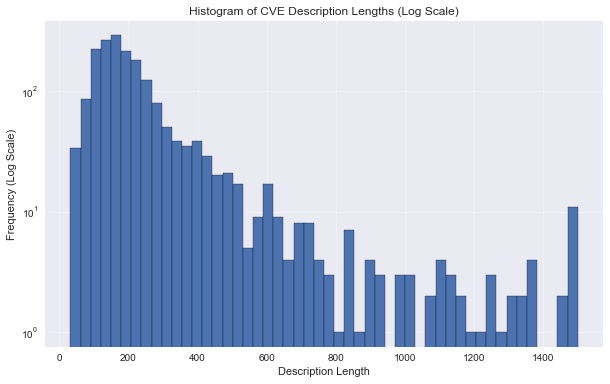

In [121]:
cisa_adp_entries_linux['description_length'] = cisa_adp_entries_linux['CVE_Description'].str.len()

# Create the histogram with log scale on y-axis
plt.figure(figsize=(10, 6))
plt.hist(cisa_adp_entries_linux['description_length'], bins=50, edgecolor='black')
plt.title('Histogram of CVE Description Lengths (Log Scale)')
plt.xlabel('Description Length')
plt.ylabel('Frequency (Log Scale)')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.grid(True, alpha=0.3)
plt.savefig('CISA_ADP_CVE_Descriptions_post.png', dpi=300, bbox_inches='tight')
plt.show()


# Remove Linux Traces from Descriptions

Many of the Linux Kernel CVE Descriptions are long because they contain traces
* But not all long CVE Descriptions are for the Linux Kernel e.g. https://nvd.nist.gov/vuln/detail/CVE-2023-38297 

Some CVEs that start with "In the Linux kernel, the following vulnerability has been resolved:" contain a trace pre examples below.

These start with
* backtrace:
* Call Trace:

There are ~40 of these in the CISA ADP CWE set.

These add relatively little context for the tokens they consume so remove them (as they directly impact batch sizes).

Also remove the numeric strings remaining.

CVE-2021-47242

In the Linux kernel, the following vulnerability has been resolved:\\n\\nmptcp: fix soft lookup in subflow_error_report()\\n\\nMaxim reported a soft lookup in subflow_error_report():\\n\\n watchdog: BUG: soft lockup - CPU#0 stuck for 22s! [swapper/0:0]\\n RIP: 0010:native_queued_spin_lock_slowpath\\n RSP: 0018:ffffa859c0003bc0 EFLAGS: 00000202\\n RAX: 0000000000000101 RBX: 0000000000000001 RCX: 0000000000000000\\n RDX: ffff9195c2772d88 RSI: 0000000000000000 RDI: ffff9195c2772d88\\n RBP: ffff9195c2772d00 R08: 00000000000067b0 R09: c6e31da9eb1e44f4\\n R10: ffff9195ef379700 R11: ffff9195edb50710 R12: ffff9195c2772d88\\n R13: ffff9195f500e3d0 R14: ffff9195ef379700 R15: ffff9195ef379700\\n FS:  0000000000000000(0000) GS:ffff91961f400000(0000) knlGS:0000000000000000\\n CS:  0010 DS: 0000 ES: 0000 CR0: 0000000080050033\\n CR2: 000000c000407000 CR3: 0000000002988000 CR4: 00000000000006f0\\n **Call Trace:\\n  <IRQ>\\n _raw_spin_lock_bh\\n subflow_error_report\\n mptcp_subflow_data_available\\n __mptcp_move_skbs_from_subflow\\n mptcp_data_ready\\n tcp_data_queue\\n tcp_rcv_established\\n tcp_v4_do_rcv\\n tcp_v4_rcv\\n ip_protocol_deliver_rcu\\n ip_local_deliver_finish\\n __netif_receive_skb_one_core\\n netif_receive_skb\\n rtl8139_poll 8139too\\n __napi_poll\\n net_rx_action\\n __do_softirq\\n __irq_exit_rcu\\n common_interrupt\\n  </IRQ>\\n\\nThe calling function - mptcp_subflow_data_available() - can be invoked\\nfrom different contexts:\\n- plain ssk socket lock\\n- ssk socket lock + mptcp_data_lock\\n- ssk socket lock + mptcp_data_lock + msk socket lock.\\n\\nSince subflow_error_report() tries to acquire the mptcp_data_lock, the\\nlatter two call chains will cause soft lookup.\\n\\nThis change addresses the issue moving the error reporting call to\\nouter functions, where the held locks list is known and the we can\\nacquire only the needed one.**

CVE-2021-47456

In the Linux kernel, the following vulnerability has been resolved:\\n\\ncan: peak_pci: peak_pci_remove(): fix UAF\\n\\nWhen remove the module peek_pci, referencing 'chan' again after\\nreleasing 'dev' will cause UAF.\\n\\nFix this by releasing 'dev' later.\\n\\nThe following log reveals it:\\n\\n[   35.961814 ] BUG: KASAN: use-after-free in peak_pci_remove+0x16f/0x270 [peak_pci]\\n[   35.963414 ] Read of size 8 at addr ffff888136998ee8 by task modprobe/5537\\n[   35.965513 ] **Call Trace:\\n[   35.965718 ]  dump_stack_lvl+0xa8/0xd1\\n[   35.966028 ]  print_address_description+0x87/0x3b0\\n[   35.966420 ]  kasan_report+0x172/0x1c0\\n[   35.966725 ]  ? peak_pci_remove+0x16f/0x270 [peak_pci]\\n[   35.967137 ]  ? trace_irq_enable_rcuidle+0x10/0x170\\n[   35.967529 ]  ? peak_pci_remove+0x16f/0x270 [peak_pci]\\n[   35.967945 ]  __asan_report_load8_noabort+0x14/0x20\\n[   35.968346 ]  peak_pci_remove+0x16f/0x270 [peak_pci]\\n[   35.968752 ]  pci_device_remove+0xa9/0x250**

CVE-2021-47242

In the Linux kernel, the following vulnerability has been resolved:\\n\\nscsi: core: Fix a use-after-free\\n\\nThere are two .exit_cmd_priv implementations. Both implementations use\\nresources associated with the SCSI host. Make sure that these resources are\\nstill available when .exit_cmd_priv is called by waiting inside\\nscsi_remove_host() until the tag set has been freed.\\n\\nThis commit fixes the following use-after-free:\\n\\n==================================================================\\nBUG: KASAN: use-after-free in srp_exit_cmd_priv+0x27/0xd0 [ib_srp]\\nRead of size 8 at addr ffff888100337000 by task multipathd/16727\\n**Call Trace:\\n <TASK>\\n dump_stack_lvl+0x34/0x44\\n print_report.cold+0x5e/0x5db\\n kasan_report+0xab/0x120\\n srp_exit_cmd_priv+0x27/0xd0 [ib_srp]\\n scsi_mq_exit_request+0x4d/0x70\\n blk_mq_free_rqs+0x143/0x410\\n __blk_mq_free_map_and_rqs+0x6e/0x100\\n blk_mq_free_tag_set+0x2b/0x160\\n scsi_host_dev_release+0xf3/0x1a0\\n device_release+0x54/0xe0\\n kobject_put+0xa5/0x120\\n device_release+0x54/0xe0\\n kobject_put+0xa5/0x120\\n scsi_device_dev_release_usercontext+0x4c1/0x4e0\\n execute_in_process_context+0x23/0x90\\n device_release+0x54/0xe0\\n kobject_put+0xa5/0x120\\n scsi_disk_release+0x3f/0x50\\n device_release+0x54/0xe0\\n kobject_put+0xa5/0x120\\n disk_release+0x17f/0x1b0\\n device_release+0x54/0xe0\\n kobject_put+0xa5/0x120\\n dm_put_table_device+0xa3/0x160 [dm_mod]\\n dm_put_device+0xd0/0x140 [dm_mod]\\n free_priority_group+0xd8/0x110 [dm_multipath]\\n free_multipath+0x94/0xe0 [dm_multipath]\\n dm_table_destroy+0xa2/0x1e0 [dm_mod]\\n __dm_destroy+0x196/0x350 [dm_mod]\\n dev_remove+0x10c/0x160 [dm_mod]\\n ctl_ioctl+0x2c2/0x590 [dm_mod]\\n dm_ctl_ioctl+0x5/0x10 [dm_mod]\\n __x64_sys_ioctl+0xb4/0xf0\\n dm_ctl_ioctl+0x5/0x10 [dm_mod]\\n __x64_sys_ioctl+0xb4/0xf0\\n do_syscall_64+0x3b/0x90\\n entry_SYSCALL_64_after_hwframe+0x46/0xb0**


CVE-2021-47441

In the Linux kernel, the following vulnerability has been resolved:\\n\\nmlxsw: thermal: Fix out-of-bounds memory accesses\\n\\nCurrently, mlxsw allows cooling states to be set above the maximum\\ncooling state supported by the driver:\\n\\n # cat /sys/class/thermal/thermal_zone2/cdev0/type\\n mlxsw_fan\\n # cat /sys/class/thermal/thermal_zone2/cdev0/max_state\\n 10\\n # echo 18 > /sys/class/thermal/thermal_zone2/cdev0/cur_state\\n # echo $?\\n 0\\n\\nThis results in out-of-bounds memory accesses when thermal state\\ntransition statistics are enabled (CONFIG_THERMAL_STATISTICS=y), as the\\ntransition table is accessed with a too large index (state) [1].\\n\\nAccording to the thermal maintainer, it is the responsibility of the\\ndriver to reject such operations [2].\\n\\nTherefore, return an error when the state to be set exceeds the maximum\\ncooling state supported by the driver.\\n\\nTo avoid dead code, as suggested by the thermal maintainer [3],\\npartially revert commit a421ce088ac8 ("mlxsw: core: Extend cooling\\ndevice with cooling levels") that tried to interpret these invalid\\ncooling states (above the maximum) in a special way. The cooling levels\\narray is not removed in order to prevent the fans going below 20% PWM,\\nwhich would cause them to get stuck at 0% PWM.\\n\\n[1]\\nBUG: KASAN: slab-out-of-bounds in thermal_cooling_device_stats_update+0x271/0x290\\nRead of size 4 at addr ffff8881052f7bf8 by task kworker/0:0/5\\n\\nCPU: 0 PID: 5 Comm: kworker/0:0 Not tainted 5.15.0-rc3-custom-45935-gce1adf704b14 #122\\nHardware name: Mellanox Technologies Ltd. "MSN2410-CB2FO"/"SA000874", BIOS 4.6.5 03/08/2016\\nWorkqueue: events_freezable_power_ thermal_zone_device_check\\n**Call Trace:\\n dump_stack_lvl+0x8b/0xb3\\n print_address_description.constprop.0+0x1f/0x140\\n kasan_report.cold+0x7f/0x11b\\n thermal_cooling_device_stats_update+0x271/0x290\\n __thermal_cdev_update+0x15e/0x4e0\\n thermal_cdev_update+0x9f/0xe0\\n step_wise_throttle+0x770/0xee0\\n thermal_zone_device_update+0x3f6/0xdf0\\n process_one_work+0xa42/0x1770\\n worker_thread+0x62f/0x13e0\\n kthread+0x3ee/0x4e0\\n ret_from_fork+0x1f/0x30\\n\\nAllocated by task 1:\\n kasan_save_stack+0x1b/0x40\\n __kasan_kmalloc+0x7c/0x90\\n thermal_cooling_device_setup_sysfs+0x153/0x2c0\\n __thermal_cooling_device_register.part.0+0x25b/0x9c0\\n thermal_cooling_device_register+0xb3/0x100\\n mlxsw_thermal_init+0x5c5/0x7e0\\n __mlxsw_core_bus_device_register+0xcb3/0x19c0\\n mlxsw_core_bus_device_register+0x56/0xb0\\n mlxsw_pci_probe+0x54f/0x710\\n local_pci_probe+0xc6/0x170\\n pci_device_probe+0x2b2/0x4d0\\n really_probe+0x293/0xd10\\n __driver_probe_device+0x2af/0x440\\n driver_probe_device+0x51/0x1e0\\n __driver_attach+0x21b/0x530\\n bus_for_each_dev+0x14c/0x1d0\\n bus_add_driver+0x3ac/0x650\\n driver_register+0x241/0x3d0\\n mlxsw_sp_module_init+0xa2/0x174\\n do_one_initcall+0xee/0x5f0\\n kernel_init_freeable+0x45a/0x4de\\n kernel_init+0x1f/0x210\\n ret_from_fork+0x1f/0x30\\n\\nThe buggy address belongs to the object at ffff8881052f7800\\n which belongs to the cache kmalloc-1k of size 1024\\nThe buggy address is located 1016 bytes inside of\\n 1024-byte region [ffff8881052f7800, ffff8881052f7c00)\\nThe buggy address belongs to the page:\\npage:0000000052355272 refcount:1 mapcount:0 mapping:0000000000000000 index:0x0 pfn:0x1052f0\\nhead:0000000052355272 order:3 compound_mapcount:0 compound_pincount:0\\nflags: 0x200000000010200(slab|head|node=0|zone=2)\\nraw: 0200000000010200 ffffea0005034800 0000000300000003 ffff888100041dc0\\nraw: 0000000000000000 0000000000100010 00000001ffffffff 0000000000000000\\npage dumped because: kasan: bad access detected\\n\\nMemory state around the buggy address:\\n ffff8881052f7a80: 00 00 00 00 00 00 04 fc fc fc fc fc fc fc fc fc\\n ffff8881052f7b00: fc fc fc fc fc fc fc fc fc fc fc fc fc fc fc fc\\n>ffff8881052f7b80: fc fc fc fc fc fc fc fc fc fc fc fc fc fc fc fc\\n                                                                ^\\n ffff8881052f7c00: fc fc fc fc fc fc fc fc fc fc fc fc fc fc fc fc\\n ffff8881052f7c80: fc fc fc fc fc fc fc fc fc fc fc fc fc fc fc fc\\n\\n[2] https://lore.kernel.org/linux-pm/9aca37cb-1629-5c67-\\n---truncated---**


CVE-2024-36905

In the Linux kernel, the following vulnerability has been resolved:\\n\\ntcp: defer shutdown(SEND_SHUTDOWN) for TCP_SYN_RECV sockets\\n\\nTCP_SYN_RECV state is really special, it is only used by\\ncross-syn connections, mostly used by fuzzers.\\n\\nIn the following crash [1], syzbot managed to trigger a divide\\nby zero in tcp_rcv_space_adjust()\\n\\nA socket makes the following state transitions,\\nwithout ever calling tcp_init_transfer(),\\nmeaning tcp_init_buffer_space() is also not called.\\n\\n         TCP_CLOSE\\nconnect()\\n         TCP_SYN_SENT\\n         TCP_SYN_RECV\\nshutdown() -> tcp_shutdown(sk, SEND_SHUTDOWN)\\n         TCP_FIN_WAIT1\\n\\nTo fix this issue, change tcp_shutdown() to not\\nperform a TCP_SYN_RECV -> TCP_FIN_WAIT1 transition,\\nwhich makes no sense anyway.\\n\\nWhen tcp_rcv_state_process() later changes socket state\\nfrom TCP_SYN_RECV to TCP_ESTABLISH, then look at\\nsk->sk_shutdown to finally enter TCP_FIN_WAIT1 state,\\nand send a FIN packet from a sane socket state.\\n\\nThis means tcp_send_fin() can now be called from BH\\ncontext, and must use GFP_ATOMIC allocations.\\n\\n[1]\\ndivide error: 0000 [#1] PREEMPT SMP KASAN NOPTI\\nCPU: 1 PID: 5084 Comm: syz-executor358 Not tainted 6.9.0-rc6-syzkaller-00022-g98369dccd2f8 #0\\nHardware name: Google Google Compute Engine/Google Compute Engine, BIOS Google 03/27/2024\\n RIP: 0010:tcp_rcv_space_adjust+0x2df/0x890 net/ipv4/tcp_input.c:767\\nCode: e3 04 4c 01 eb 48 8b 44 24 38 0f b6 04 10 84 c0 49 89 d5 0f 85 a5 03 00 00 41 8b 8e c8 09 00 00 89 e8 29 c8 48 0f af c3 31 d2 <48> f7 f1 48 8d 1c 43 49 8d 96 76 08 00 00 48 89 d0 48 c1 e8 03 48\\nRSP: 0018:ffffc900031ef3f0 EFLAGS: 00010246\\nRAX: 0c677a10441f8f42 RBX: 000000004fb95e7e RCX: 0000000000000000\\nRDX: 0000000000000000 RSI: 0000000000000000 RDI: 0000000000000000\\nRBP: 0000000027d4b11f R08: ffffffff89e535a4 R09: 1ffffffff25e6ab7\\nR10: dffffc0000000000 R11: ffffffff8135e920 R12: ffff88802a9f8d30\\nR13: dffffc0000000000 R14: ffff88802a9f8d00 R15: 1ffff1100553f2da\\nFS:  00005555775c0380(0000) GS:ffff8880b9500000(0000) knlGS:0000000000000000\\nCS:  0010 DS: 0000 ES: 0000 CR0: 0000000080050033\\nCR2: 00007f1155bf2304 CR3: 000000002b9f2000 CR4: 0000000000350ef0\\nCall **Trace:\\n <TASK>\\n  tcp_recvmsg_locked+0x106d/0x25a0 net/ipv4/tcp.c:2513\\n  tcp_recvmsg+0x25d/0x920 net/ipv4/tcp.c:2578\\n  inet6_recvmsg+0x16a/0x730 net/ipv6/af_inet6.c:680\\n  sock_recvmsg_nosec net/socket.c:1046 [inline]\\n  sock_recvmsg+0x109/0x280 net/socket.c:1068\\n  ____sys_recvmsg+0x1db/0x470 net/socket.c:2803\\n  ___sys_recvmsg net/socket.c:2845 [inline]\\n  do_recvmmsg+0x474/0xae0 net/socket.c:2939\\n  __sys_recvmmsg net/socket.c:3018 [inline]\\n  __do_sys_recvmmsg net/socket.c:3041 [inline]\\n  __se_sys_recvmmsg net/socket.c:3034 [inline]\\n  __x64_sys_recvmmsg+0x199/0x250 net/socket.c:3034\\n  do_syscall_x64 arch/x86/entry/common.c:52 [inline]\\n  do_syscall_64+0xf5/0x240 arch/x86/entry/common.c:83\\n entry_SYSCALL_64_after_hwframe+0x77/0x7f\\nRIP: 0033:0x7faeb6363db9\\nCode: 28 00 00 00 75 05 48 83 c4 28 c3 e8 c1 17 00 00 90 48 89 f8 48 89 f7 48 89 d6 48 89 ca 4d 89 c2 4d 89 c8 4c 8b 4c 24 08 0f 05 <48> 3d 01 f0 ff ff 73 01 c3 48 c7 c1 b8 ff ff ff f7 d8 64 89 01 48\\nRSP: 002b:00007ffcc1997168 EFLAGS: 00000246 ORIG_RAX: 000000000000012b\\nRAX: ffffffffffffffda RBX: 0000000000000000 RCX: 00007faeb6363db9\\nRDX: 0000000000000001 RSI: 0000000020000bc0 RDI: 0000000000000005\\nRBP: 0000000000000000 R08: 0000000000000000 R09: 000000000000001c\\nR10: 0000000000000122 R11: 0000000000000246 R12: 0000000000000000\\nR13: 0000000000000000 R14: 0000000000000001 R15: 0000000000000001**

In [122]:
cisa_adp_entries

,cve_id,Container,adp_providerMetadata_orgId,adp_providerMetadata_shortName,adp_providerMetadata_dateUpdated,CVE_Description,cna_providerMetadata_orgId,cna_providerMetadata_shortName,cna_providerMetadata_dateUpdated,CWE_ID,CWE_Description
18,CVE-2021-35559,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-25T16:05:50.566Z,"Vulnerability in the Java SE, Oracle GraalVM E...",NaN,NaN,NaN,CWE-400,CWE-400 Uncontrolled Resource Consumption
23,CVE-2021-26928,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-05-01T15:18:46.280Z,BIRD through 2.0.7 does not provide functional...,NaN,NaN,NaN,CWE-306,CWE-306 Missing Authentication for Critical Fu...
29,CVE-2021-26918,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-05-01T15:09:54.735Z,The ProBot bot through 2021-02-08 for Discord ...,NaN,NaN,NaN,CWE-434,CWE-434 Unrestricted Upload of File with Dange...
114,CVE-2021-34983,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-05-08T15:08:02.757Z,NETGEAR Multiple Routers httpd Missing Authent...,NaN,NaN,NaN,CWE-120,CWE-120 Buffer Copy without Checking Size of I...
148,CVE-2021-33990,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-07-12T15:32:38.330Z,Liferay Portal 6.2.5 allows Command=FileUpload...,NaN,NaN,NaN,CWE-78,CWE-78 Improper Neutralization of Special Elem...
...,...,...,...,...,...,...,...,...,...,...,...
30231,CVE-2024-37762,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-07-08T15:13:35.601Z,MachForm up to version 21 is affected by an au...,NaN,NaN,NaN,CWE-434,CWE-434 Unrestricted Upload of File with Dange...
30233,CVE-2024-37634,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-13T20:21:11.912Z,TOTOLINK A3700R V9.1.2u.6165_20211012 was disc...,NaN,NaN,NaN,CWE-121,CWE-121 Stack-based Buffer Overflow
30250,CVE-2024-37535,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-10T12:55:15.708Z,GNOME VTE before 0.76.3 allows an attacker to ...,NaN,NaN,NaN,CWE-400,CWE-400 Uncontrolled Resource Consumption
30254,CVE-2024-37019,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-04T14:49:54.923Z,Northern.tech Mender Enterprise before 3.6.4 a...,NaN,NaN,NaN,CWE-287,CWE-287 Improper Authentication


In [123]:
def contains_digit(word):
    return any(char.isdigit() for char in word)

def process_linux_cve_description(text):
    # Check if the text starts with "In the Linux kernel"
    if text.lower().startswith("in the linux kernel"):
        
        # Find the index of "trace:" (case-insensitive)
        trace_index = re.search(r'trace:', text, re.IGNORECASE)
        if trace_index:
            # Truncate the text from "trace:"
            text = text[:trace_index.start()]

        # Find the index of "trace:" (case-insensitive)
        odebug_index = re.search(r'ODEBUG:', text, re.IGNORECASE)
        if odebug_index:
            # Truncate the text from "ODEBUG:"
            text = text[:odebug_index.start()]
    
    # Split the text into words
    words = re.findall(r'\b\S+\b', text)
    
    # Filter out words containing digits
    filtered_words = [word for word in words if not contains_digit(word)]
    
    # Join the filtered words back into a string
    filtered_text = ' '.join(filtered_words)
    
    return filtered_text.strip()
        

cisa_adp_entries_linux = cisa_adp_entries.copy()
cisa_adp_entries_linux['CVE_Description'] = cisa_adp_entries['CVE_Description'].apply(process_linux_cve_description)

cisa_adp_entries_linux

,cve_id,Container,adp_providerMetadata_orgId,adp_providerMetadata_shortName,adp_providerMetadata_dateUpdated,CVE_Description,cna_providerMetadata_orgId,cna_providerMetadata_shortName,cna_providerMetadata_dateUpdated,CWE_ID,CWE_Description
18,CVE-2021-35559,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-25T16:05:50.566Z,Vulnerability in the Java SE Oracle GraalVM En...,NaN,NaN,NaN,CWE-400,CWE-400 Uncontrolled Resource Consumption
23,CVE-2021-26928,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-05-01T15:18:46.280Z,BIRD through does not provide functionality fo...,NaN,NaN,NaN,CWE-306,CWE-306 Missing Authentication for Critical Fu...
29,CVE-2021-26918,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-05-01T15:09:54.735Z,The ProBot bot through for Discord might allow...,NaN,NaN,NaN,CWE-434,CWE-434 Unrestricted Upload of File with Dange...
114,CVE-2021-34983,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-05-08T15:08:02.757Z,NETGEAR Multiple Routers httpd Missing Authent...,NaN,NaN,NaN,CWE-120,CWE-120 Buffer Copy without Checking Size of I...
148,CVE-2021-33990,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-07-12T15:32:38.330Z,Liferay Portal allows Command=FileUpload&Type=...,NaN,NaN,NaN,CWE-78,CWE-78 Improper Neutralization of Special Elem...
...,...,...,...,...,...,...,...,...,...,...,...
30231,CVE-2024-37762,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-07-08T15:13:35.601Z,MachForm up to version is affected by an authe...,NaN,NaN,NaN,CWE-434,CWE-434 Unrestricted Upload of File with Dange...
30233,CVE-2024-37634,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-13T20:21:11.912Z,TOTOLINK was discovered to contain a stack ove...,NaN,NaN,NaN,CWE-121,CWE-121 Stack-based Buffer Overflow
30250,CVE-2024-37535,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-10T12:55:15.708Z,GNOME VTE before allows an attacker to cause a...,NaN,NaN,NaN,CWE-400,CWE-400 Uncontrolled Resource Consumption
30254,CVE-2024-37019,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-04T14:49:54.923Z,Northern.tech Mender Enterprise before and bef...,NaN,NaN,NaN,CWE-287,CWE-287 Improper Authentication


In [124]:
cisa_adp_entries_linux['description_length'] = cisa_adp_entries_linux['CVE_Description'].str.len()

# Sort by description length in descending order and select top 10
top_10_longest = cisa_adp_entries_linux.sort_values('description_length', ascending=False).head(20)
top_10_longest

,cve_id,Container,adp_providerMetadata_orgId,adp_providerMetadata_shortName,adp_providerMetadata_dateUpdated,CVE_Description,cna_providerMetadata_orgId,cna_providerMetadata_shortName,cna_providerMetadata_dateUpdated,CWE_ID,CWE_Description,description_length
7758,CVE-2023-38297,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-04-23T18:51:30.611Z,An issue was discovered in a third-party com.f...,NaN,NaN,NaN,CWE-284,CWE-284 Improper Access Control,2274
14404,CVE-2024-26960,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-05-21T18:26:00.252Z,In the Linux kernel the following vulnerabilit...,NaN,NaN,NaN,CWE-362,CWE-362 Concurrent Execution using Shared Reso...,2140
26445,CVE-2024-29210,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-05-07T18:36:21.996Z,A local privilege escalation LPE vulnerability...,NaN,NaN,NaN,CWE-269,CWE-269 Improper Privilege Management,2039
28839,CVE-2024-36894,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-03T16:04:02.070Z,In the Linux kernel the following vulnerabilit...,NaN,NaN,NaN,CWE-362,CWE-362 Concurrent Execution using Shared Reso...,1891
12765,CVE-2024-35982,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-05-20T13:38:54.495Z,In the Linux kernel the following vulnerabilit...,NaN,NaN,NaN,CWE-835,CWE-835 Loop with Unreachable Exit Condition (...,1851
303,CVE-2021-47371,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-05T19:24:59.850Z,In the Linux kernel the following vulnerabilit...,NaN,NaN,NaN,CWE-400,CWE-400 Uncontrolled Resource Consumption,1777
25541,CVE-2024-27405,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-05-17T15:50:14.970Z,In the Linux kernel the following vulnerabilit...,NaN,NaN,NaN,CWE-476,CWE-476 NULL Pointer Dereference,1732
14050,CVE-2024-26924,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-04-29T16:46:24.026Z,In the Linux kernel the following vulnerabilit...,NaN,NaN,NaN,CWE-476,CWE-476 NULL Pointer Dereference,1701
12948,CVE-2024-35814,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-05T20:21:27.934Z,In the Linux kernel the following vulnerabilit...,NaN,NaN,NaN,CWE-1055,CWE-1055 Multiple Inheritance from Concrete Cl...,1632
12947,CVE-2024-35814,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-05T20:21:27.934Z,In the Linux kernel the following vulnerabilit...,NaN,NaN,NaN,CWE-119,CWE-119 Improper Restriction of Operations wit...,1632


### Truncate CVE Descriptions to 1500 characters

In [125]:
# Function to truncate string
def truncate_string(text, max_length=1500):
    return text[:max_length] if len(text) > max_length else text


# Truncate CVE_Description to max length 1500 characters
cisa_adp_entries_linux['CVE_Description'] = cisa_adp_entries_linux['CVE_Description'].apply(truncate_string)


# Save as CSV file with proper quoting
cisa_adp_entries_linux.to_csv(cwe_only_cisa_adp_linux_output_file_path, index=False,quoting=csv.QUOTE_ALL, escapechar='\\') # safe CSV


## Summary Stats

In [126]:
print("\nData Summary:")
print(f"{len(df)} \t Total number of entries")
print(f"{df.CWE_ID.count()} \t Number of entries with CWE_ID ")
print(f"{len(cisa_adp_entries)} \t Number of CISA ADP entries with CWE_ID")
print(f"\nNumber of unique CWE_IDs \n{df.CWE_ID.value_counts()}")




Data Summary:
30257 	 Total number of entries
10430 	 Number of entries with CWE_ID 
1884 	 Number of CISA ADP entries with CWE_ID

Number of unique CWE_IDs 
CWE-79      1620
CWE-89       658
CWE-121      429
CWE-862      426
CWE-352      355
            ... 
CWE-409        1
CWE-424        1
CWE-1068       1
CWE-657        1
CWE-1240       1
Name: CWE_ID, Length: 422, dtype: int64


# Cumulative Plot of CWEs assigned by CISA ADP

In [127]:
def plot_cumulative_and_daily_entries(df):
    if 'adp_providerMetadata_dateUpdated' not in df.columns:
        print("Column 'adp_providerMetadata_dateUpdated' not found in the DataFrame")
        return

    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Convert dateUpdated to datetime
    df_copy.loc[:, 'dateUpdated'] = pd.to_datetime(df_copy['adp_providerMetadata_dateUpdated'], format='%Y-%m-%dT%H:%M:%S.%fZ')

    # Group by date and count entries for each day
    daily_counts = df_copy.groupby(df_copy['dateUpdated'].dt.date).size().reset_index(name='count')
    daily_counts['dateUpdated'] = pd.to_datetime(daily_counts['dateUpdated'])

    # Sort the dataframe by date
    daily_counts = daily_counts.sort_values('dateUpdated')

    # Calculate cumulative counts
    daily_counts['cumulative_count'] = daily_counts['count'].cumsum()

    # Create the plot with a light background
    plt.style.use('seaborn')
    fig, ax1 = plt.subplots(figsize=(20, 10), facecolor='#F0F0F0')
    ax1.set_facecolor('#F0F0F0')

    # Plot cumulative count
    color = 'darkblue'
    ax1.set_xlabel('Date', color='black', fontweight='bold')
    ax1.set_ylabel('Cumulative Count', color=color, fontweight='bold')
    ax1.plot(daily_counts['dateUpdated'], daily_counts['cumulative_count'], color=color, linewidth=2)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for daily count
    ax2 = ax1.twinx()
    color = 'darkred'
    ax2.set_ylabel('Daily Count', color=color, fontweight='bold')
    ax2.bar(daily_counts['dateUpdated'], daily_counts['count'], alpha=0.3, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Set title and adjust layout
    plt.title('Cumulative and Daily Count of CISA ADP CWE Entries Over Time', color='black', fontweight='bold', fontsize=16)
    fig.tight_layout()

    # Rotate and align the tick labels so they look better
    fig.autofmt_xdate()

    # Add a grid for better readability
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Add a legend
    ax1.legend(['Cumulative Count'], loc='upper left', frameon=True, facecolor='white', edgecolor='black')
    ax2.legend(['Daily Count'], loc='upper right', frameon=True, facecolor='white', edgecolor='black')

    # Save the plot
    plt.savefig('cumulative_and_daily_entries_plot.png', dpi=300, bbox_inches='tight')
    print("Cumulative and daily plot has been saved as 'cumulative_and_daily_entries_plot.png'")

    # Show some statistics
    print(f"\nDate range: from {daily_counts['dateUpdated'].min().date()} to {daily_counts['dateUpdated'].max().date()}")
    print(f"Total number of entries: {daily_counts['cumulative_count'].iloc[-1]}")
    print(f"Maximum daily entries: {daily_counts['count'].max()} on {daily_counts.loc[daily_counts['count'].idxmax(), 'dateUpdated'].date()}")
    print(f"Average daily entries: {daily_counts['count'].mean():.2f}")


Cumulative and daily plot has been saved as 'cumulative_and_daily_entries_plot.png'

Date range: from 2024-04-18 to 2024-07-18
Total number of entries: 1884
Maximum daily entries: 101 on 2024-07-16
Average daily entries: 25.81


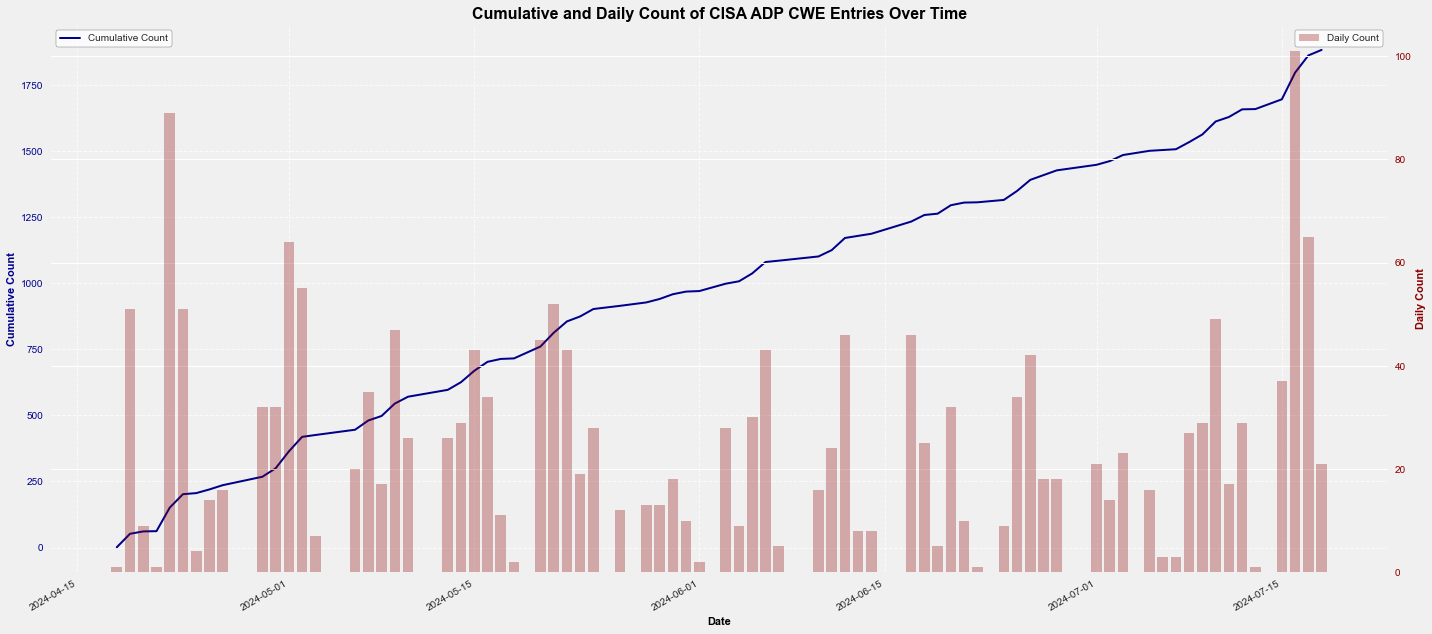

In [128]:
plot_cumulative_and_daily_entries(cisa_adp_entries)